---
author: Zeel B Patel
badges: true
categories: ML, GP
description: A guide to download low-cost sensor data from OpenAQ
title: Download low-cost data from OpenAQ
date: '2023-07-26'
toc: true
---

In [2]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from glob import glob

from geopy.geocoders import Nominatim

OpenAQ has an aws s3 bucket that contains all the data to download for free. This is a guide to download the data from the bucket. If you have enough space and bandwidth, aws s3 commands are the fastest way to download the data. If you don't have enough space/bandwidth or you want to download specific data only then follow along.

Acknowledgement: Much help is taken from ChatGPT for some complex Linux commands.

We will mostly use the following commands:
```bash
aws s3 ls
aws s3 cp
```

Scenario 1: We want to download PurpleAir sensors data for Delhi for entire 2022. I am taking Delhi's example since there are far lesser sensors in Delhi than in the US. So, it will be easier for this demo.

Some statistics that I have calculated for PurpleAir sensors in US are as follows:

| Country | Number of sensors | Total size | years |
|---------|-------------------|------------|-------|
| USA | 22497 | 90.945 GB | 2018, 2019, 2020, 2021, 2022, 2023 |

Let's see how to calculate these statistics for India.

In [3]:
!aws s3 --no-sign-request ls s3://openaq-data-archive/records/csv.gz/provider=purpleair/country=in/ > /tmp/in.txt

The output of above command contains all sensor IDs within India. These sensor IDs are assigned by OpenAQ and they are different from PurpleAir "sensor_index". The output looks like the following. 

In [4]:
with open('/tmp/in.txt', 'r') as f:
    lines = [line.strip() for line in f.readlines()]
  
print(f"Number of locations = {len(lines)}\n")
print(*lines[:3], sep='\n')

Number of locations = 623

PRE locationid=160485/
PRE locationid=218334/
PRE locationid=218336/


Counting total size of files:

In [5]:
!aws s3 --no-sign-request ls s3://openaq-data-archive/records/csv.gz/provider=purpleair/country=in/ --recursive > /tmp/in_files.txt

In [6]:
!awk '{ sum += $3 } END { print (sum/1024/1024/1024) " GB"}' /tmp/in_files.txt

1.20947 GB


Number of years:

In [7]:
!cat /tmp/in_files.txt | grep -oP 'year=\K\w+' | sort | uniq

2019
2020
2021
2022
2023


Let's find out which sensors among these belong to Delhi.

In [8]:
!cat /tmp/in.txt | grep -oP 'locationid=\K\w+' | sort | uniq > /tmp/in_locations.txt

Now we use OpenAQ REST API. It has limit of 300 requests per 5 minutes. After the limit exceeds, it will return an error.

In [14]:
url = 'https://api.openaq.org/v2/locations'
params = {
    'limit': 1000,
    'country_id': 'IN',
    "modelName": "PurpleAir Sensor"
}

# Request headers
headers = {
    'accept': 'application/json'
}

response = requests.get(url, params=params, headers=headers)

if response.status_code == 200:
    data = response.json()
else:
    print(response.status_code, response.reason)

500 Internal Server Error


In [10]:
df = pd.DataFrame(data['results'])
df.shape

NameError: name 'data' is not defined

The following method works but takes too much time since it is online:

In [49]:
def get_city_name(coords):
    latitude = coords["latitude"]
    longitude = coords["longitude"]
    geolocator = Nominatim(user_agent="myGeocoder")  # Replace "myGeocoder" with your desired user agent
    location = geolocator.reverse((latitude, longitude), exactly_one=True)

    if location:
        address = location.raw.get('address', {})
        city = address.get('city', '')
        return city

    return None

df["city"] = df["coordinates"].apply(get_city_name)
df

,id,city,name,entity,country,sources,isMobile,isAnalysis,parameters,sensorType,coordinates,lastUpdated,firstUpdated,measurements,bounds,manufacturers
0,318146,Gangtok,NASA_AQCS_201_cpa,None,IN,None,False,None,"[{'id': 135, 'unit': 'particles/cm³', 'count':...",None,"{'latitude': 27.31013, 'longitude': 88.59687}",2023-07-26T02:34:05+00:00,2022-04-23T07:42:24+00:00,1168071,"[88.59687, 27.31013, 88.59687, 27.31013]","[{'modelName': 'PurpleAir Sensor', 'manufactur..."
1,220706,Gangtok,NASA_AQCS_139,None,IN,None,False,None,"[{'id': 100, 'unit': 'c', 'count': 28600, 'ave...",None,"{'latitude': 27.310116, 'longitude': 88.59682}",2023-07-26T02:34:04+00:00,2021-02-17T09:56:06+00:00,2205110,"[88.59682, 27.310116, 88.59682, 27.310116]","[{'modelName': 'PurpleAir Sensor', 'manufactur..."
2,66673,Hisar,NASA_AQCS_160,None,IN,None,False,None,"[{'id': 132, 'unit': 'mb', 'count': 28651, 'av...",None,"{'latitude': 29.146254, 'longitude': 75.72236}",2023-07-26T02:33:56+00:00,2021-01-19T23:59:16+00:00,2396934,"[75.72236, 29.146254, 75.72236, 29.146254]","[{'modelName': 'PurpleAir Sensor', 'manufactur..."
3,72977,Bengaluru,UT Sensor 101,None,IN,None,False,None,"[{'id': 126, 'unit': 'particles/cm³', 'count':...",None,"{'latitude': 13.045313, 'longitude': 77.573395}",2023-07-26T02:33:55+00:00,2021-01-14T01:18:23+00:00,2498544,"[77.573395, 13.045313, 77.573395, 13.045313]","[{'modelName': 'PurpleAir Sensor', 'manufactur..."
4,235916,Bengaluru,UW Sensor 311,None,IN,None,False,None,"[{'id': 130, 'unit': 'particles/cm³', 'count':...",None,"{'latitude': 13.048528, 'longitude': 77.582275}",2023-07-26T02:33:49+00:00,2021-09-16T12:29:52+00:00,1773924,"[77.582275, 13.048528, 77.582275, 13.048528]","[{'modelName': 'PurpleAir Sensor', 'manufactur..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,73922,New Delhi District,US Embassy A,None,IN,None,False,None,"[{'id': 2, 'unit': 'µg/m³', 'count': 347, 'ave...",None,"{'latitude': 28.5979, 'longitude': 77.1847}",2021-02-05T18:25:34+00:00,2021-01-08T12:12:29+00:00,2082,"[77.1847, 28.5979, 77.1847, 28.5979]","[{'modelName': 'PurpleAir Sensor', 'manufactur..."
605,73924,New Delhi District,US Embassy B,None,IN,None,False,None,"[{'id': 2, 'unit': 'µg/m³', 'count': 347, 'ave...",None,"{'latitude': 28.5982, 'longitude': 77.1837}",2021-02-05T18:23:59+00:00,2021-01-08T12:11:29+00:00,2082,"[77.1837, 28.5982, 77.1837, 28.5982]","[{'modelName': 'PurpleAir Sensor', 'manufactur..."
606,219370,Bhubaneswar Municipal Corporation,Bhubaneswar India,None,IN,None,False,None,"[{'id': 2, 'unit': 'µg/m³', 'count': 180, 'ave...",None,"{'latitude': 20.2853, 'longitude': 85.7685}",2021-02-03T10:18:41+00:00,2021-02-03T03:02:39+00:00,1080,"[85.7685, 20.2853, 85.7685, 20.2853]","[{'modelName': 'PurpleAir Sensor', 'manufactur..."
607,71465,Gurugram District,NASA_AQCS_152,None,IN,None,False,None,"[{'id': 1, 'unit': 'µg/m³', 'count': 1, 'avera...",None,"{'latitude': 28.4522, 'longitude': 77.0949}",2021-01-14T01:18:54+00:00,2021-01-14T01:18:54+00:00,6,"[77.0949, 28.4522, 77.0949, 28.4522]","[{'modelName': 'PurpleAir Sensor', 'manufactur..."


Now, we use another method of shapefile to do this:

In [56]:
!wget --no-check-certificate "https://groups.google.com/group/datameet/attach/29b74b1aef5f2f13/Delhi.zip?part=0.1" -O /tmp/delhi.zip
!unzip -o /tmp/delhi.zip -d /tmp/delhi

--2023-07-26 08:37:34--  https://groups.google.com/group/datameet/attach/29b74b1aef5f2f13/Delhi.zip?part=0.1
Resolving groups.google.com (groups.google.com)... 216.239.32.177, 216.239.36.177, 216.239.38.177, ...
Connecting to groups.google.com (groups.google.com)|216.239.32.177|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://06895207363394598426.googlegroups.com/attach/29b74b1aef5f2f13/Delhi.zip?part=0.1&vt=ANaJVrEpUPnptnb4Y-J5gJRBVJ29K0pIGKzeBG7492Ume1tyn1MY5eTDbztxP0Hdbc7u8XhmH_GbemY_HD60x5OvDhr7M2ib1h8YfDmlNxFefazGPgmAUj0 [following]
--2023-07-26 08:37:35--  https://06895207363394598426.googlegroups.com/attach/29b74b1aef5f2f13/Delhi.zip?part=0.1&vt=ANaJVrEpUPnptnb4Y-J5gJRBVJ29K0pIGKzeBG7492Ume1tyn1MY5eTDbztxP0Hdbc7u8XhmH_GbemY_HD60x5OvDhr7M2ib1h8YfDmlNxFefazGPgmAUj0
Resolving 06895207363394598426.googlegroups.com (06895207363394598426.googlegroups.com)... 142.251.10.137, 2404:6800:4003:c0f::89
Connecting to 06895207363394598426.goog

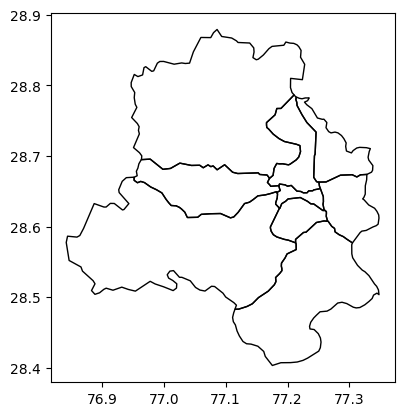

In [59]:
gdf = gpd.read_file('/tmp/delhi/Districts.shp')
gdf.plot(color="none", edgecolor="black");

In [61]:
# check if a point is within Delhi
def is_within_delhi(coords):
    point = Point(coords["longitude"], coords["latitude"])
    for i, row in gdf.iterrows():
        if row.geometry.contains(point):
            return True
    return False

df["is_within_delhi"] = df["coordinates"].apply(is_within_delhi)

In [64]:
delhi_df = df[df["is_within_delhi"]]
delhi_df.shape

(311, 17)

In [65]:
delhi_df.city.value_counts()

                      194
New Delhi District    112
Dwarka                  3
Ghaziabad               2
Name: city, dtype: int64

Seems like many points were not detected by the online geopy encoder.

Now, we know that out of 623, 311 sensors belong to Delhi. Let's download the data for these sensors. For illustration, I will download data for 3 sensors for year 2022 and month of Jan.

In [75]:
# dump delhi_df.id to a file
delhi_df.id.to_csv('/tmp/delhi_locations.txt', index=False, header=False)
!head -n3 /tmp/delhi_locations.txt

274208
221227
273205


In [80]:
!head -n3 /tmp/delhi_locations.txt > /tmp/delhi_locations_3.txt
!while read -r sensor_id; do aws s3 --no-sign-request cp s3://openaq-data-archive/records/csv.gz/provider=purpleair/country=in/locationid=$sensor_id/year=2022/month=01 /tmp/delhi_data --recursive; done < /tmp/delhi_locations_3.txt

download: s3://openaq-data-archive/records/csv.gz/provider=purpleair/country=in/locationid=274208/year=2022/month=01/location-274208-20220107.csv.gz to ../../../../tmp/delhi_data/location-274208-20220107.csv.gz
download: s3://openaq-data-archive/records/csv.gz/provider=purpleair/country=in/locationid=274208/year=2022/month=01/location-274208-20220120.csv.gz to ../../../../tmp/delhi_data/location-274208-20220120.csv.gz
download: s3://openaq-data-archive/records/csv.gz/provider=purpleair/country=in/locationid=274208/year=2022/month=01/location-274208-20220131.csv.gz to ../../../../tmp/delhi_data/location-274208-20220131.csv.gz
download: s3://openaq-data-archive/records/csv.gz/provider=purpleair/country=in/locationid=274208/year=2022/month=01/location-274208-20220122.csv.gz to ../../../../tmp/delhi_data/location-274208-20220122.csv.gz
download: s3://openaq-data-archive/records/csv.gz/provider=purpleair/country=in/locationid=274208/year=2022/month=01/location-274208-20220130.csv.gz to ../.

Verify if we got all the sensors data as we needed.

In [94]:
!ls /tmp/delhi_data/location-221227* | wc -l
!ls /tmp/delhi_data/location-274208* | wc -l
!ls /tmp/delhi_data/location-273205* | wc -l

27
10
15


In [97]:
sensor_df = pd.read_csv('/tmp/delhi_data/location-274208-20220107.csv.gz')
sensor_df.parameter.value_counts()

pm10     64
pm25     64
pm1      64
um010    64
um025    64
um100    64
Name: parameter, dtype: int64